In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

import re, os
import unicodedata
import json

import nltk
import nltk.sentiment
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from time import strftime

from wordcloud import WordCloud

from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

import acquire
import prepare_jag

import spacy
pd.set_option('display.max_colwidth', None)



### Acquire data

We will be using the 1000 labeled notes in `test.csv`

In [38]:
df = prepare_jag.prep_train()

Test, notes, and features loaded.
Merged dataframes
Renamed 'pn_history' column to 'original'
Added a basic clean column lowercaseing and removing special characters
Added stemmed column with tokenized words and stopwords removed
Added lemmatized column with lemmatized words and stopwords removed
Data preparation complete


In [39]:
df.head(1)

id  case_num  pn_num  feature_num  \
0  00016_000         0      16            0   

                                                      feature_text  \
0  Family-history-of-MI-OR-Family-history-of-myocardial-infarction   

                         annotation     location  \
0  ['dad with recent heart attcak']  ['696 724']   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 original  \
0  HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with "thyroid disease," dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        clean  \
0  hpi 17yo presents palpitations patient reports 3-4 months intermittent episodes heart beating pounding chest 2 days ago soccer game episode time chest pressure felt going pass lose conciousness note patient endorses abusing adderall primarily study 1-3 times per week recent soccer game took adderrall night morning game denies shortness breath diaphoresis fevers chills headache fatigue changes sleep changes vision hearing abdominal paun changes bowel urinary habits pmhx none rx uses friends adderrall fhx mom thyroid disease dad recent heart attcak none immunizations date shx freshmen college endorses 3-4 drinks 3 nights week weekends denies tabacco endorses trying marijuana sexually active girlfriend x 1 year uses condoms   

                                                                                                                                                                                                                                                                                       

In [40]:
df.shape

(14300, 11)

---

In [5]:
df.case_num.value_counts().sort_index()

0    1300
1    1300
2    1700
3    1600
4    1000
5    1800
6    1200
7     900
8    1800
9    1700
Name: case_num, dtype: int64

In [41]:
# Look at distribution of cases
cases = pd.concat([df.case_num.value_counts().sort_index(), df.case_num.value_counts(normalize = True)], axis = 1)
cases.columns = ['n', 'percent']
cases

n   percent
0  1300  0.090909
1  1300  0.090909
2  1700  0.118881
3  1600  0.111888
4  1000  0.069930
5  1800  0.125874
6  1200  0.083916
7   900  0.062937
8  1800  0.125874
9  1700  0.118881

<AxesSubplot:title={'center':'Case Representation'}, ylabel='n'>

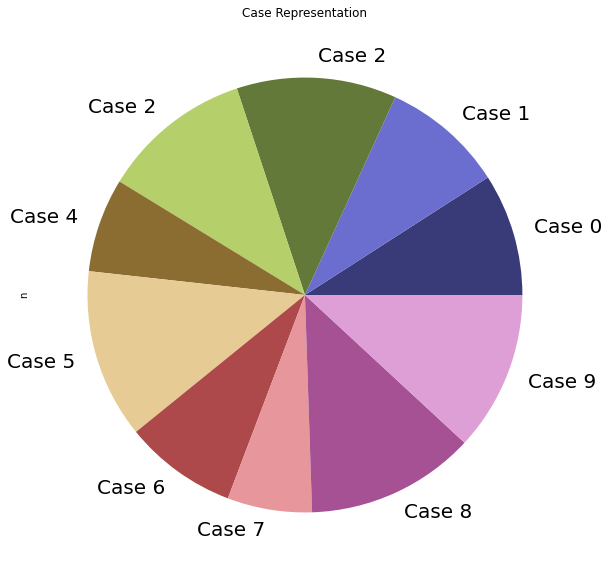

In [55]:
cases.n.plot.pie(
    figsize=[10,10], 
    title='Case Representation',
    labels=['Case 0', 'Case 1','Case 2','Case 2','Case 4','Case 5','Case 6','Case 7','Case 8','Case 9',],
    fontsize=20,
    cmap='tab20b'
    )

Make word lists by case from cleaned words



In [8]:
df.head(1)

id  case_num  pn_num  feature_num  \
0  00016_000         0      16            0   

                                                      feature_text  \
0  Family-history-of-MI-OR-Family-history-of-myocardial-infarction   

                         annotation     location  \
0  ['dad with recent heart attcak']  ['696 724']   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 original  \
0  HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with "thyroid disease," dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        clean  \
0  hpi 17yo presents palpitations patient reports 3-4 months intermittent episodes heart beating pounding chest 2 days ago soccer game episode time chest pressure felt going pass lose conciousness note patient endorses abusing adderall primarily study 1-3 times per week recent soccer game took adderrall night morning game denies shortness breath diaphoresis fevers chills headache fatigue changes sleep changes vision hearing abdominal paun changes bowel urinary habits pmhx none rx uses friends adderrall fhx mom thyroid disease dad recent heart attcak none immunizations date shx freshmen college endorses 3-4 drinks 3 nights week weekends denies tabacco endorses trying marijuana sexually active girlfriend x 1 year uses condoms   

                                                                                                                                                                                                                                                                                       

In [56]:
#Make word lists by case_num_xs from clean words
case0_words = ' '.join(df[df.case_num == 0].clean).split()
case1_words = ' '.join(df[df.case_num == 1].clean).split()
case2_words = ' '.join(df[df.case_num == 2].clean).split()
case3_words = ' '.join(df[df.case_num == 3].clean).split()
case4_words = ' '.join(df[df.case_num == 4].clean).split()
case5_words = ' '.join(df[df.case_num == 5].clean).split()
case6_words = ' '.join(df[df.case_num == 6].clean).split()
case7_words = ' '.join(df[df.case_num == 7].clean).split()
case8_words = ' '.join(df[df.case_num == 8].clean).split()
case9_words = ' '.join(df[df.case_num == 9].clean).split()
all_words = ' '.join(df.clean).split()


In [57]:
# Look at word list lengths
print('Case0 words: '+str(len(case0_words)))
print('Case1 words: '+str(len(case1_words)))
print('Case2 words: '+str(len(case2_words)))
print('Case3 words: '+str(len(case3_words)))
print('Case4 words: '+str(len(case4_words)))
print('Case5 words: '+str(len(case5_words)))
print('Case6 words: '+str(len(case6_words)))
print('Case7 words: '+str(len(case7_words)))
print('Case8 words: '+str(len(case8_words)))
print('Case9 words: '+str(len(case9_words)))
print('All words: '+str(len(all_words)))

Case0 words: 126022
Case1 words: 129025
Case2 words: 175950
Case3 words: 154512
Case4 words: 93390
Case5 words: 176058
Case6 words: 116700
Case7 words: 93204
Case8 words: 183600
Case9 words: 149379
All words: 1397840


In [58]:
# Calculate word frequencies
case0_freq = pd.Series(case0_words).value_counts()
case1_freq = pd.Series(case1_words).value_counts()
case2_freq = pd.Series(case2_words).value_counts()
case3_freq = pd.Series(case3_words).value_counts()
case4_freq = pd.Series(case4_words).value_counts()
case5_freq = pd.Series(case5_words).value_counts()
case6_freq = pd.Series(case6_words).value_counts()
case7_freq = pd.Series(case7_words).value_counts()
case8_freq = pd.Series(case8_words).value_counts()
case9_freq = pd.Series(case9_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [60]:
# Look at 20 most common words
word_counts = (pd.concat([all_freq, case0_freq, case1_freq, case2_freq, case3_freq, case4_freq, case5_freq, case6_freq, case7_freq, case8_freq, case9_freq], axis = 1, sort = True)
                .set_axis(['all', 'Case0', 'Case1', 'Case2', 'Case3', 'Case4', 'Case5', 'Case6', 'Case7', 'Case8', 'Case9'], axis = 1, inplace = False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
word_counts.sort_values(by = 'all', ascending = False).head(50)

all  Case0  Case1  Case2  Case3  Case4  Case5  Case6  Case7  \
no            44474   3419   4628   5780   5904   2660   6264   2820   3384   
pain          24728    832   4992   1479   7312    540   1044   4380    801   
none          17816   1729   2132   1224   1936   1340   3672   1008   1773   
denies        17746   1807   1508   2193   1600   1570   2088   1584   1089   
ago           16876   1248   2665   2720    848    630   4122    780   1287   
2             12877    728   1495   2346   2624    430   2124    216   1449   
last          11483   1833   1898   2652    528    290   1512    732   1206   
pmh           10607   1001    949   1241   1184    790   1242    888    756   
-              9681    585    663   1054   1328    570   1116   1044    612   
weeks          9316     39    949    476    704   1130   3186      0    279   
3              9240    364    247   2499    208    200   1980    204    378   
changes        9234   1170    351   1615    624    930   1224    420    702   
months         9167   1430   1417   1411   1456     60    810    216   2331   
days           8786    702   1482   2703     16    130    540   1068   1017   
use            8782   1027    923    816    992    640   1188   1020    702   
ros            8328    754    689    850   1056    650   1026    816    513   
meds           7485    702    754    901    832    450    918    600    540   
past           7335    559   1209    833    576    390   1008    420    945   
patient        7103    533    689    799   1072    410   1170    612    396   
active         7026    754    858   1037    688    370    864    684    594   
week           6943   1027     78    986   1536    460    648    204     36   
chest          6799   1716    156    238    544    330    972   2052     90   
fh             6777    637    559    799    928    460    792    576    432   
day            6521    247    819    850   1024    360   1008    432    522   
years          6446     65      0   2448    640     70   1296     96    576   
sexually       6356    598    793    952    672    340    810    588    549   
sh             6330    546    572    714    784    490    774    492    450   
yo             6319    663    598    748    736    500    684    564    477   
allergies      6248    611    572    782    656    400    720    624    432   
history        6217    416    572    867    496    330   1008    564    486   
psh            6145    533    559    578    720    430    756    552    441   
episodes       6039   1443    728    119    272    230   2556     72      0   
10             5974    221   1222    136   1456     70     18    924    270   
5              5902     13   1079    544   1248     60   1566    348    378   
periods        5881      0    221   3536      0    120     90      0   1863   
also           5832    468    377    782    672    550    630    504    342   
reports        5826    299    377    629    592    420    648    408    432   
nausea         5802    260    754    493   1248    110   1188    384    162   
f              5443     26    793    816      0    490    828     60    558   
1              5406    338    169    952   1440    260    378    516    270   
weight         5285    559    312    799    528    510    810    312    441   
hx             5192    663    507    697    624    310    702    420    279   
drinks         5105   1287    429    425    368    420     36    408    198   
nkda           4888    429    481    493    576    320    594    480    252   
year           4828    598    299   1224    480    260    612    204    333   
since          4730    260    507    204    848    230    486    360    144   
pt             4682    520    390    510    512    260    360    432    270   
palpitations   4587    715     65    136    128    500   2538    240     54   
negative       4526    455    442    527    528    220    702    396    261   
headache       4451    195    104    187    160    290    234    1

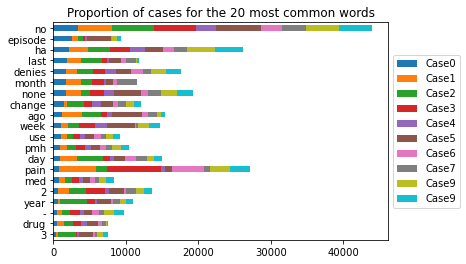

In [13]:
# figure out the percentage of language in words
(word_counts
 .assign(p_case0 = word_counts.Case0 / word_counts['all'],
        p_case1 = word_counts.Case1 / word_counts['all'],
        p_case2 = word_counts.Case2 / word_counts['all'],
        p_case3 = word_counts.Case3 / word_counts['all'],
        p_case4 = word_counts.Case4 / word_counts['all'],
        p_case5 = word_counts.Case5 / word_counts['all'],
        p_case6 = word_counts.Case6 / word_counts['all'],
        p_case7 = word_counts.Case7 / word_counts['all'],
        p_case8 = word_counts.Case8 / word_counts['all'],
        p_case9 = word_counts.Case9 / word_counts['all'])
        
 .sort_values(by = 'all')
 [['Case0', 'Case1', 'Case2', 'Case3', 'Case4', 'Case5', 'Case6', 'Case7', 'Case9', 'Case9']]
 .tail(20)
 .sort_values('Case0')
 .plot.barh(stacked=True))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Proportion of cases for the 20 most common words');

### Look at bigrams by case

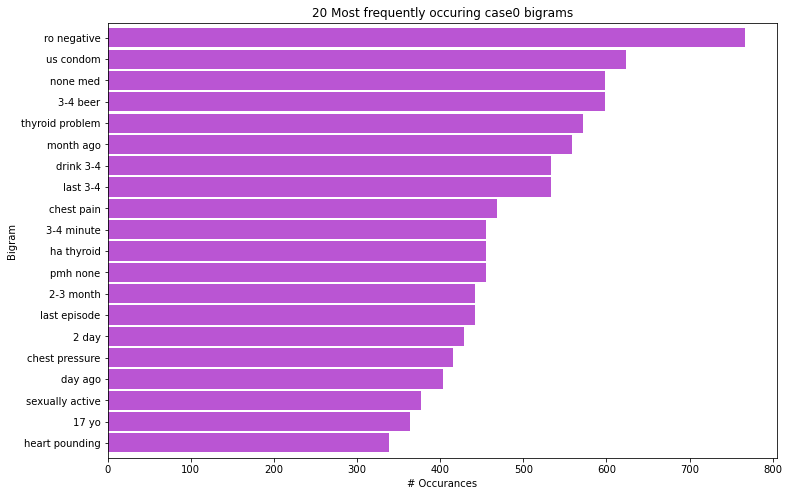

In [14]:
# Calculate Case 0bigrams
case0_bigrams = (pd.Series(nltk.ngrams(case0_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case0 Bigrams
case0_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case0 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case0_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

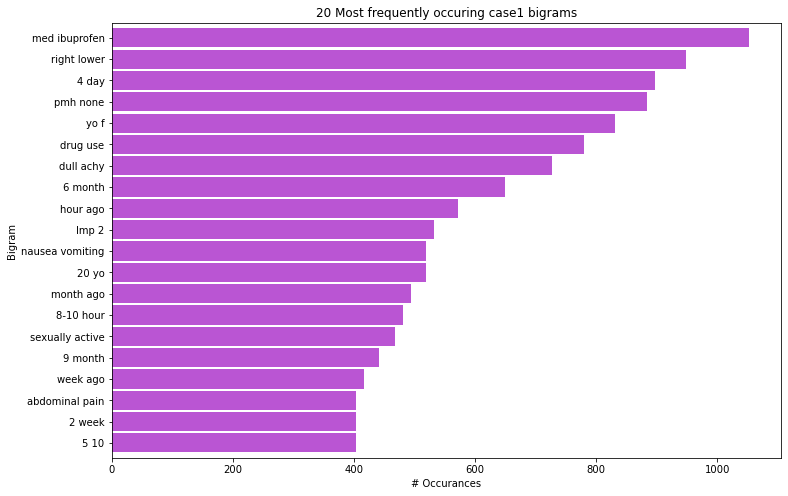

In [15]:
# Calculate Case 1 bigrams
case1_bigrams = (pd.Series(nltk.ngrams(case1_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case1 Bigrams
case1_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case1 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case1_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

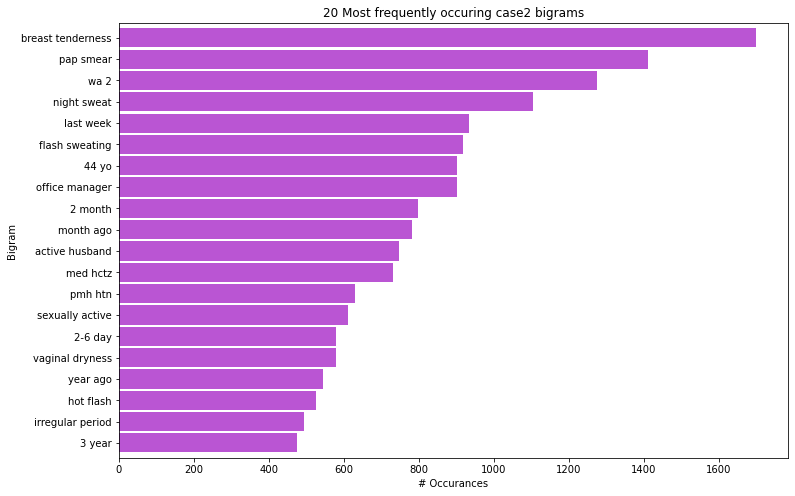

In [16]:
# Calculate Case 2 bigrams
case2_bigrams = (pd.Series(nltk.ngrams(case2_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case2 Bigrams
case2_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case2 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case2_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

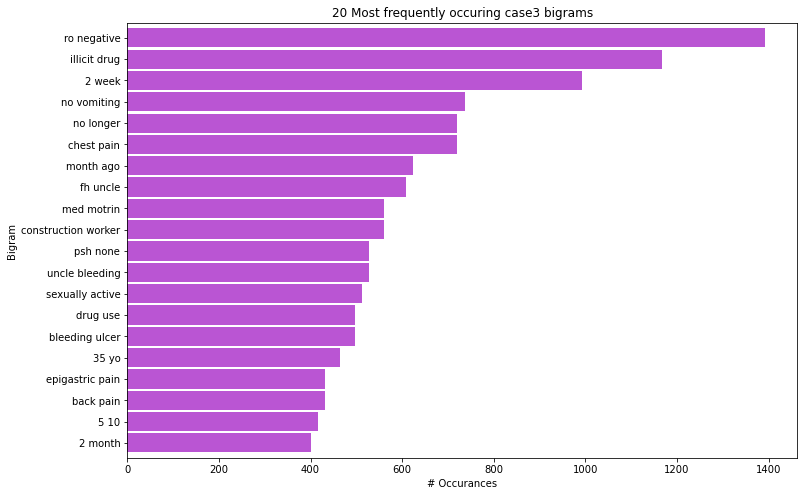

In [17]:
# Calculate Case 3 bigrams
case3_bigrams = (pd.Series(nltk.ngrams(case3_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case3 Bigrams
case3_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case3 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case3_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

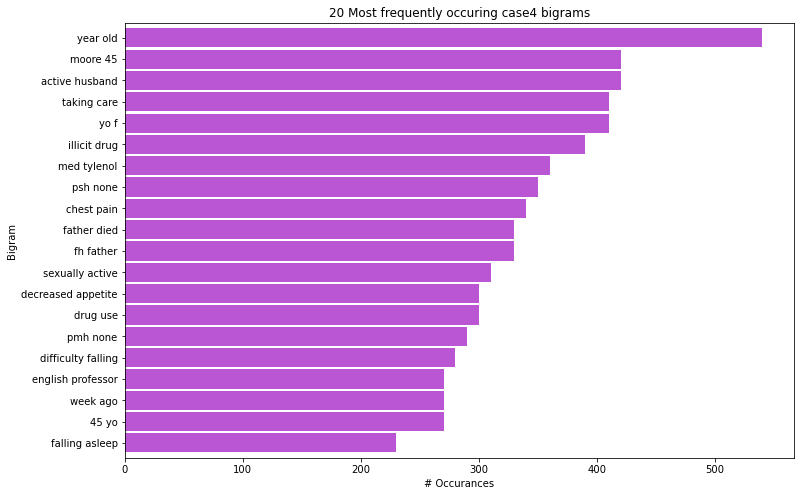

In [18]:
# Calculate Case 4 bigrams
case4_bigrams = (pd.Series(nltk.ngrams(case4_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case4 Bigrams
case4_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case4 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case4_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

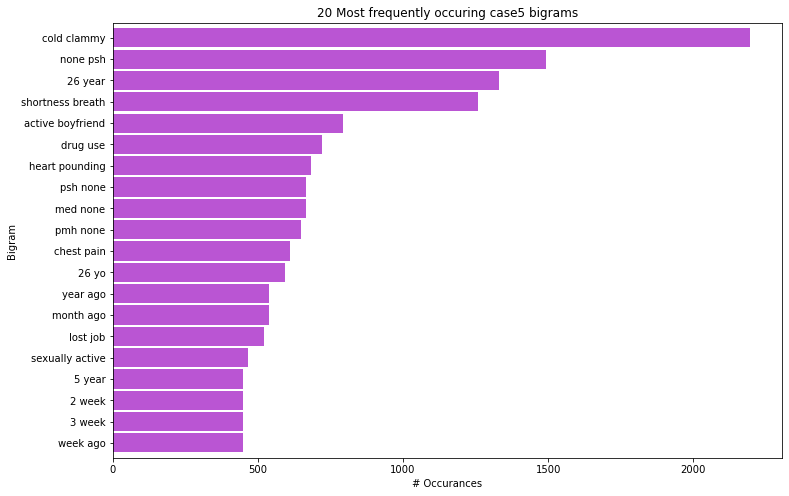

In [19]:
# Calculate Case 5bigrams
case5_bigrams = (pd.Series(nltk.ngrams(case5_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case5 Bigrams
case5_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case5 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case5_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

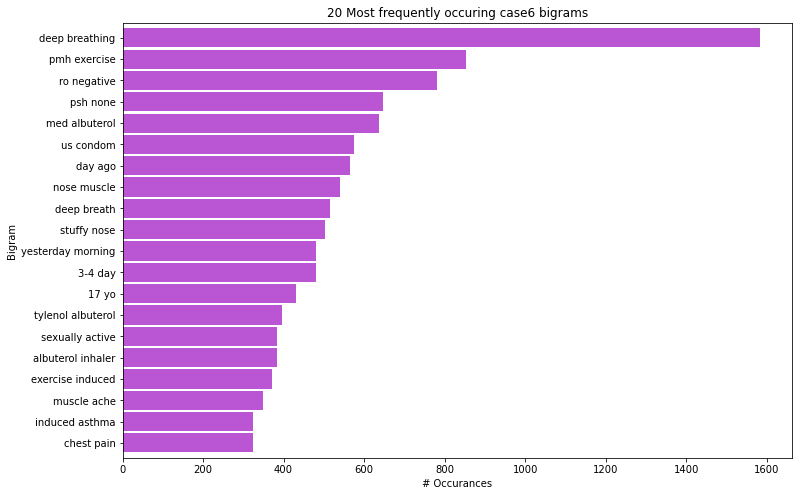

In [20]:
# Calculate Case 6 bigrams
case6_bigrams = (pd.Series(nltk.ngrams(case6_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case6 Bigrams
case6_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case6 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case6_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

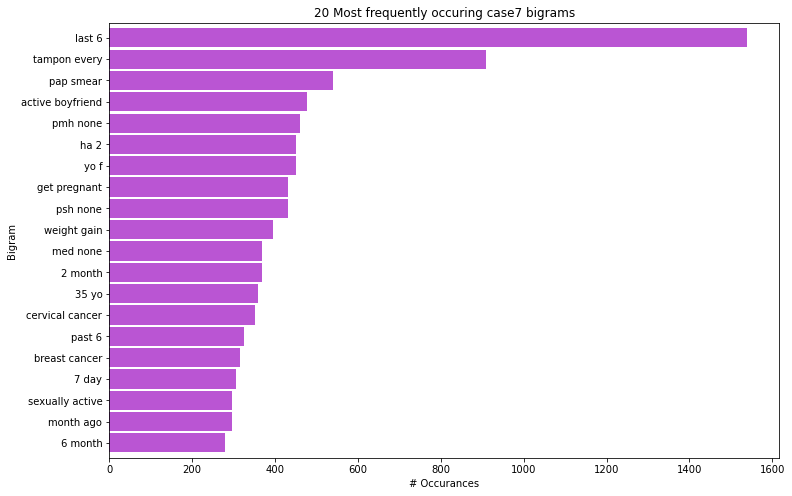

In [21]:
# Calculate Case 7 bigrams
case7_bigrams = (pd.Series(nltk.ngrams(case7_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case7 Bigrams
case7_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case7 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case7_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

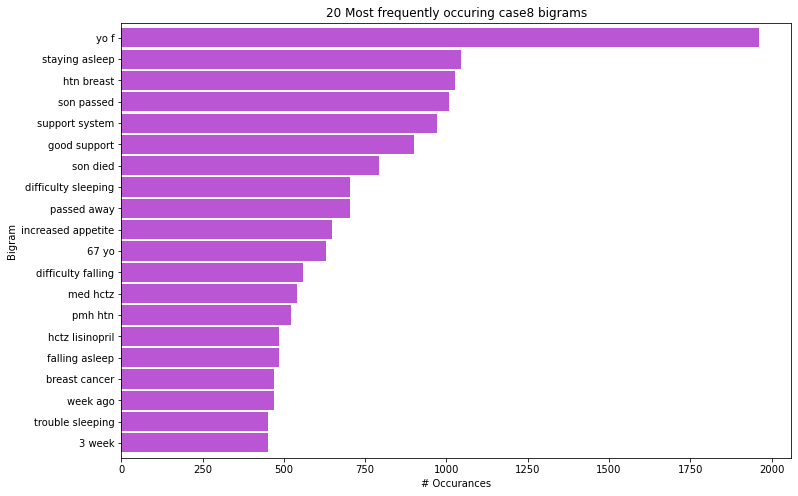

In [22]:
# Calculate Case 8 bigrams
case8_bigrams = (pd.Series(nltk.ngrams(case8_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case8 Bigrams
case8_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case8 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case8_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

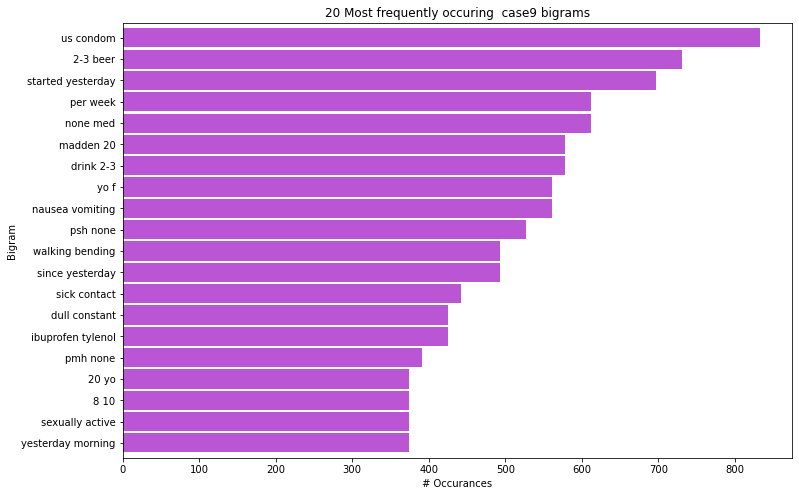

In [23]:
# Calculate Case 9 bigrams
case9_bigrams = (pd.Series(nltk.ngrams( case9_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top  case9 Bigrams
case9_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring  case9 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels =  case9_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

[ ] Trigrams?

---

### Word Clouds

In [24]:
# Create word clouds for all words and language families
all_cloud = WordCloud(background_color = 'white', height = 1600, width = 800).generate(' '.join(all_words))
case0_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case0_words))
case1_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case1_words))
case2_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case2_words))
case3_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case3_words))
case4_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case4_words))
case5_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case5_words))
case6_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case6_words))
case7_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case7_words))
case8_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case8_words))
case9_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case9_words))



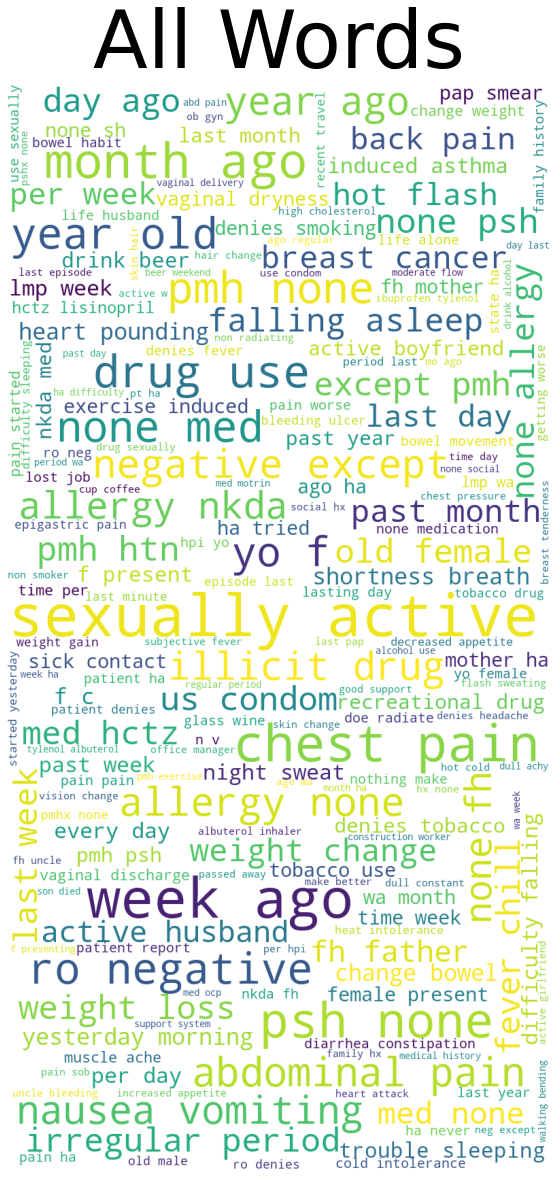

In [25]:
plt.figure(figsize = (10, 20))
plt.imshow(all_cloud);
plt.title('All Words', fontsize=80)
plt.axis('off');

(-0.5, 799.5, 799.5, -0.5)

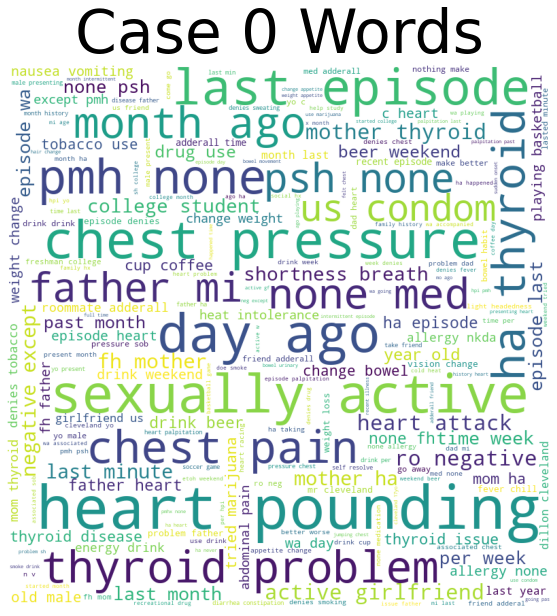

In [26]:
plt.figure(figsize = (10, 10))
plt.imshow(case0_cloud);
plt.title('Case 0 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

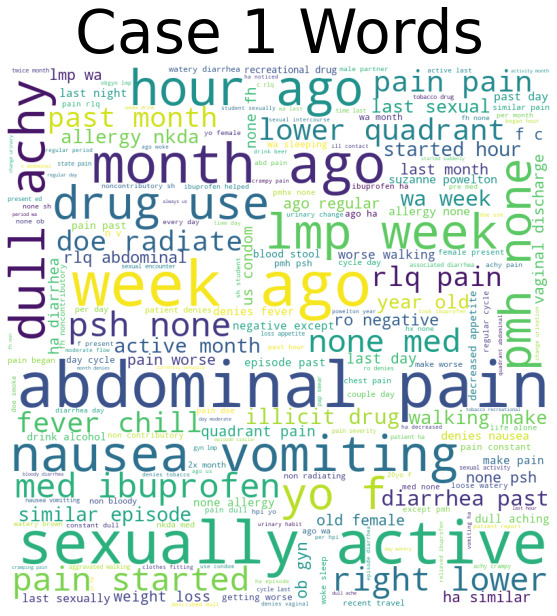

In [27]:
plt.figure(figsize = (10, 10))
plt.imshow(case1_cloud);
plt.title('Case 1 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

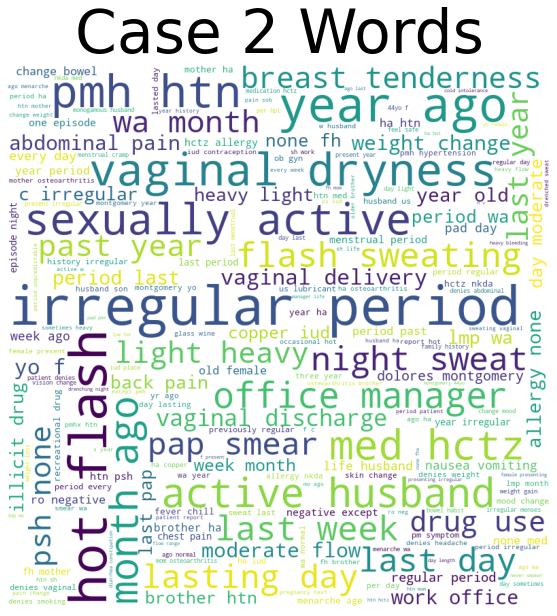

In [28]:
plt.figure(figsize = (10, 10))
plt.imshow(case2_cloud);
plt.title('Case 2 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

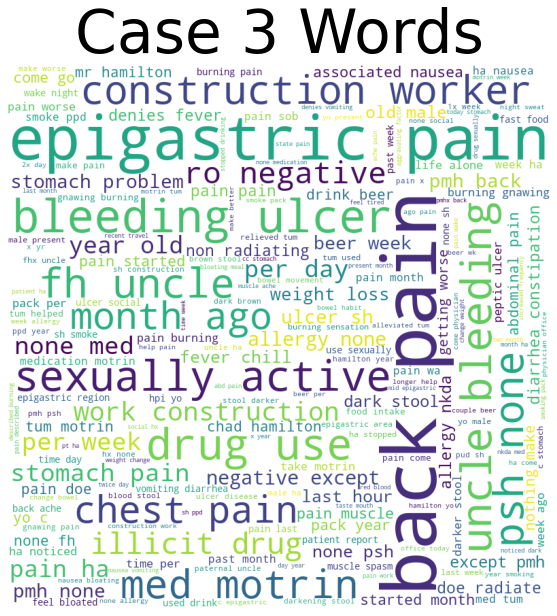

In [29]:
plt.figure(figsize = (10, 10))
plt.imshow(case3_cloud);
plt.title('Case 3 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

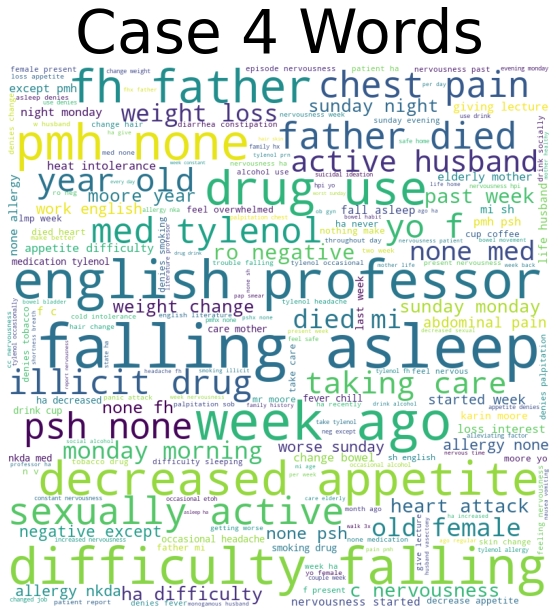

In [30]:
plt.figure(figsize = (10, 10))
plt.imshow(case4_cloud);
plt.title('Case 4 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

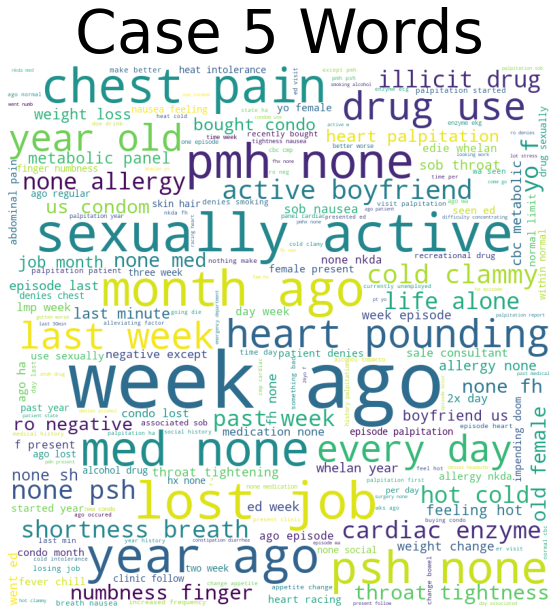

In [31]:
plt.figure(figsize = (10, 10))
plt.imshow(case5_cloud);
plt.title('Case 5 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

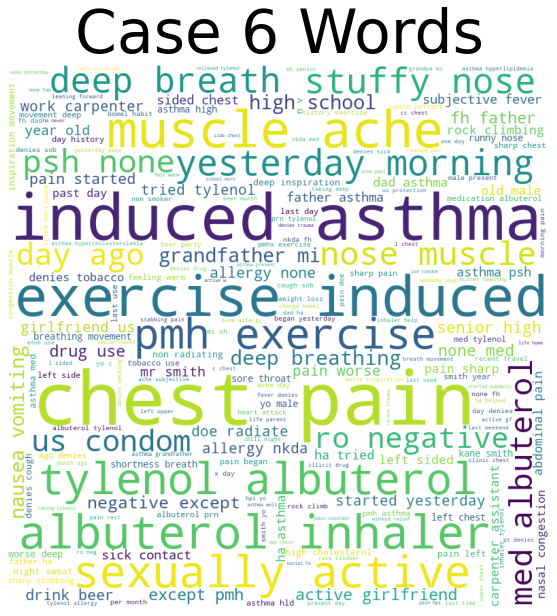

In [32]:
plt.figure(figsize = (10, 10))
plt.imshow(case6_cloud);
plt.title('Case 6 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

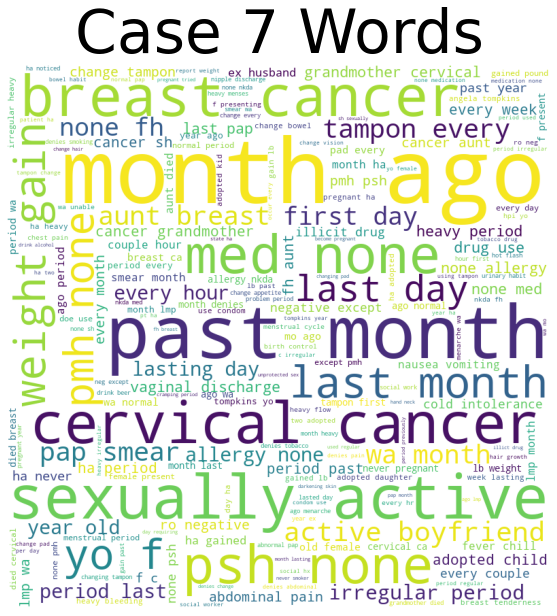

In [33]:
plt.figure(figsize = (10, 10))
plt.imshow(case7_cloud);
plt.title('Case 7 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

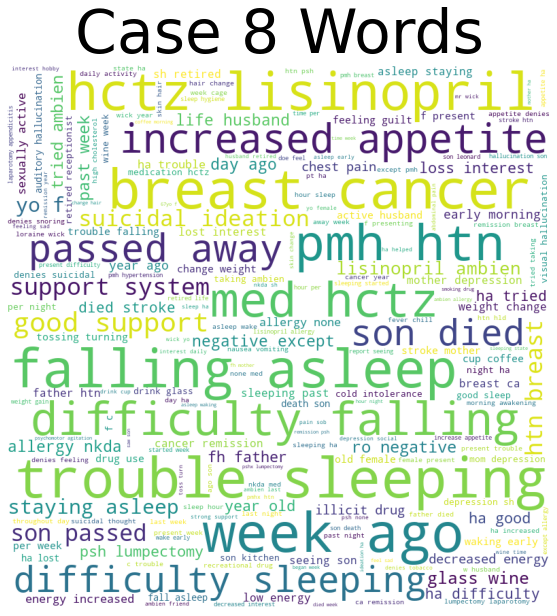

In [34]:
plt.figure(figsize = (10, 10))
plt.imshow(case8_cloud);
plt.title('Case 8 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

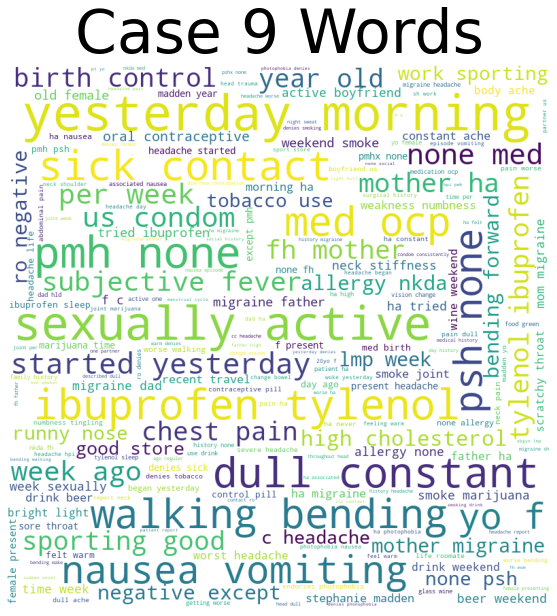

In [35]:
plt.figure(figsize = (10, 10))
plt.imshow(case9_cloud);
plt.title('Case 9 Words', fontsize=60)
plt.axis('off')
